
Random Forest - RECALL SCORE - Processing Dataset: diabetes.csv (Target: Outcome)

Dataset: diabetes.csv | Classifier: Random Forest

Regression Coefficients:
Entropy  Coefficient (β)
    H_D        19.253553
 H_pred         0.111852
H_local        -3.647098

Intercept (β₀): -13.92481
Model R² score: 0.60007
MSE: 0.00051
RMSE: 0.02259

Observed vs Predicted Recall:
 Index  Observed  Predicted  Difference
     0  0.688816   0.678026    0.010790
     1  0.663519   0.633773    0.029746
     2  0.664657   0.645039    0.019618
     3  0.641235   0.627738    0.013497
     4  0.576018   0.638240   -0.062222
     5  0.675000   0.738026   -0.063026
     6  0.709259   0.699084    0.010176
     7  0.700657   0.708210   -0.007554
     8  0.646049   0.688731   -0.042682
     9  0.688024   0.703426   -0.015402
    10  0.752632   0.742412    0.010219
    11  0.725556   0.702778    0.022778
    12  0.707045   0.711758   -0.004714
    13  0.717778   0.694975    0.022803
    14  0.683100   0.709677   -

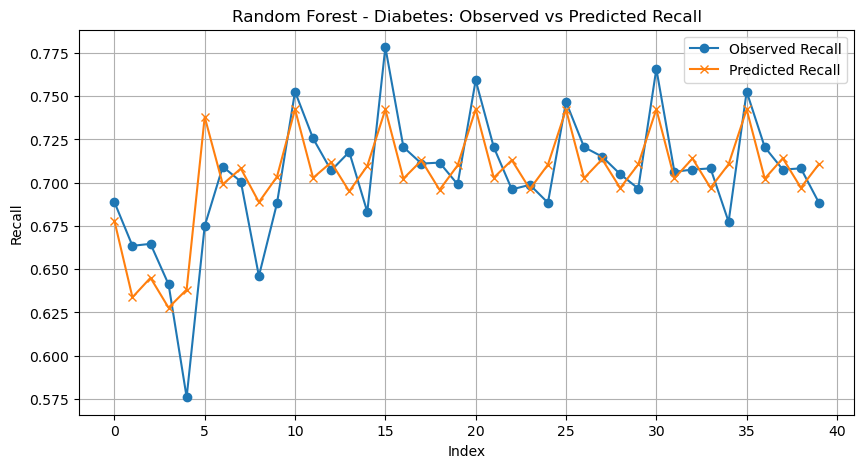

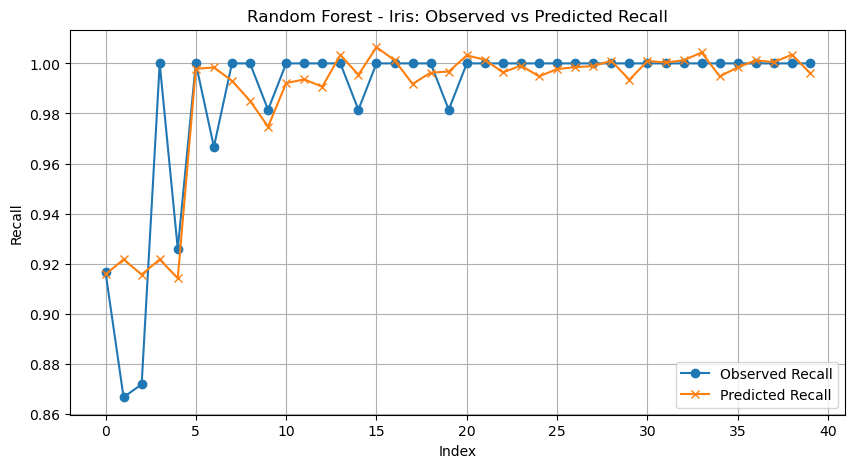

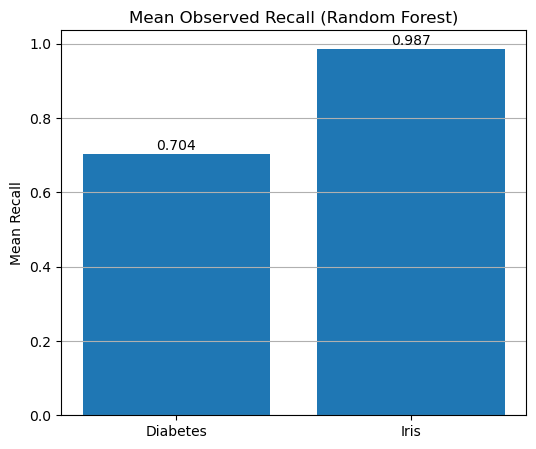

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, mean_squared_error
from scipy.stats import entropy
from sklearn.linear_model import LinearRegression

# Function to compute active components for Recall: H_D, H_pred, H_local
def compute_entropies_and_recall(n_estimators, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    probs = rf.predict_proba(X_test)

    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)

    # H_D: class distribution entropy from training set
    class_probs = np.bincount(y_train) / len(y_train)
    H_D = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_local: entropy of test set class distribution
    class_probs_test = np.bincount(y_test) / len(y_test)
    H_local = entropy(class_probs_test, base=2)

    return H_D, H_pred, H_local, rec

datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("Iris.csv", "Species")
]

for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"Random Forest - RECALL SCORE - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        data = pd.read_csv(csv_file)
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        data = data.dropna()
        
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        records = []
        for n_est in [1, 10, 50, 100, 150, 200, 250, 300]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_D, H_pred, H_local, rec = compute_entropies_and_recall(n_est, test_size=split)
                records.append({
                    "n_estimators": n_est,
                    "split": split,
                    "H_D": H_D,
                    "H_pred": H_pred,
                    "H_local": H_local,
                    "Recall": rec
                })
        
        df = pd.DataFrame(records)
        X_reg = df[["H_D", "H_pred", "H_local"]].values
        y_reg = df["Recall"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        coeffs = pd.DataFrame({
            "Entropy": ["H_D", "H_pred", "H_local"],
            "Coefficient (β)": model.coef_
        })
        
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: Random Forest")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted Recall:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table:")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        print(f"\nSummary Statistics:")
        print(f"Mean Observed Recall: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted Recall: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# ==========================================================
# Random Forest - RECALL - Diabetes
# ==========================================================

obs_diabetes_rf = [
    0.688816,0.663519,0.664657,0.641235,0.576018,
    0.675000,0.709259,0.700657,0.646049,0.688024,
    0.752632,0.725556,0.707045,0.717778,0.683100,
    0.778289,0.720556,0.711045,0.711605,0.699058,
    0.759211,0.720556,0.696119,0.698765,0.688419,
    0.746711,0.720556,0.715045,0.704938,0.696596,
    0.765789,0.706296,0.707582,0.708272,0.677386,
    0.752632,0.720556,0.707582,0.708272,0.688419
]

pred_diabetes_rf = [
    0.678026,0.633773,0.645039,0.627738,0.638240,
    0.738026,0.699084,0.708210,0.688731,0.703426,
    0.742412,0.702778,0.711758,0.694975,0.709677,
    0.742373,0.702359,0.712845,0.695865,0.710014,
    0.742450,0.702870,0.713039,0.696311,0.710449,
    0.742247,0.702594,0.713569,0.696884,0.710593,
    0.742512,0.702457,0.713996,0.697043,0.710658,
    0.742326,0.702334,0.714106,0.697099,0.710710
]


# ==========================================================
# Random Forest - RECALL - Iris
# ==========================================================

obs_iris_rf = [
    0.916667,0.866667,0.871795,1.000000,0.925926,
    1.000000,0.966667,1.000000,1.000000,0.981481,
    1.000000,1.000000,1.000000,1.000000,0.981481,
    1.000000,1.000000,1.000000,1.000000,0.981481,
    1.000000,1.000000,1.000000,1.000000,1.000000,
    1.000000,1.000000,1.000000,1.000000,1.000000,
    1.000000,1.000000,1.000000,1.000000,1.000000,
    1.000000,1.000000,1.000000,1.000000,1.000000
]

pred_iris_rf = [
    0.915724,0.921712,0.915659,0.921712,0.914178,
    0.997841,0.998385,0.993091,0.985036,0.974730,
    0.992139,0.993603,0.990704,1.003368,0.995485,
    1.006461,1.001260,0.991812,0.996309,0.996735,
    1.003204,1.001460,0.996396,0.999118,0.994844,
    0.997730,0.998497,0.998943,1.001023,0.993447,
    1.000981,1.000369,1.001236,1.004366,0.994824,
    0.998428,1.001210,1.000493,1.003506,0.996143
]


# ==========================================================
# 1. Line Plot – Diabetes Recall
# ==========================================================

plt.figure(figsize=(10,5))
plt.plot(obs_diabetes_rf, marker='o', label="Observed Recall")
plt.plot(pred_diabetes_rf, marker='x', label="Predicted Recall")
plt.title("Random Forest - Diabetes: Observed vs Predicted Recall")
plt.xlabel("Index")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()


# ==========================================================
# 2. Line Plot – Iris Recall
# ==========================================================

plt.figure(figsize=(10,5))
plt.plot(obs_iris_rf, marker='o', label="Observed Recall")
plt.plot(pred_iris_rf, marker='x', label="Predicted Recall")
plt.title("Random Forest - Iris: Observed vs Predicted Recall")
plt.xlabel("Index")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()


# ==========================================================
# 3. Bar Chart – Mean Recall
# ==========================================================

mean_diabetes = sum(obs_diabetes_rf) / len(obs_diabetes_rf)
mean_iris = sum(obs_iris_rf) / len(obs_iris_rf)

plt.figure(figsize=(6,5))
plt.bar(["Diabetes", "Iris"], [mean_diabetes, mean_iris])
plt.text(0, mean_diabetes + 0.01, f"{mean_diabetes:.3f}", ha='center')
plt.text(1, mean_iris + 0.01, f"{mean_iris:.3f}", ha='center')
plt.title("Mean Observed Recall (Random Forest)")
plt.ylabel("Mean Recall")
plt.grid(axis='y')
plt.show()


SVM - RECALL SCORE - Processing Dataset: diabetes.csv (Target: Outcome)

Dataset: diabetes.csv | Classifier: SVM

Regression Coefficients:
Entropy  Coefficient (β)
    H_D       -28.066894
 H_pred         0.805635
H_local        -9.153859

Intercept (β₀): 34.75159
Model R² score: 0.31762
MSE: 0.00487
RMSE: 0.06979

Observed vs Predicted Recall:
 Index  Observed  Predicted  Difference
     0  0.500000   0.608759   -0.108759
     1  0.500000   0.594616   -0.094616
     2  0.500000   0.574672   -0.074672
     3  0.500000   0.572596   -0.072596
     4  0.500000   0.607341   -0.107341
     5  0.500000   0.606593   -0.106593
     6  0.500000   0.592260   -0.092260
     7  0.500000   0.574382   -0.074382
     8  0.500000   0.570429   -0.070429
     9  0.500000   0.603201   -0.103201
    10  0.691447   0.618177    0.073270
    11  0.643704   0.603922    0.039782
    12  0.638567   0.578562    0.060005
    13  0.633827   0.575306    0.058522
    14  0.633465   0.602503    0.030962
    15  0.76

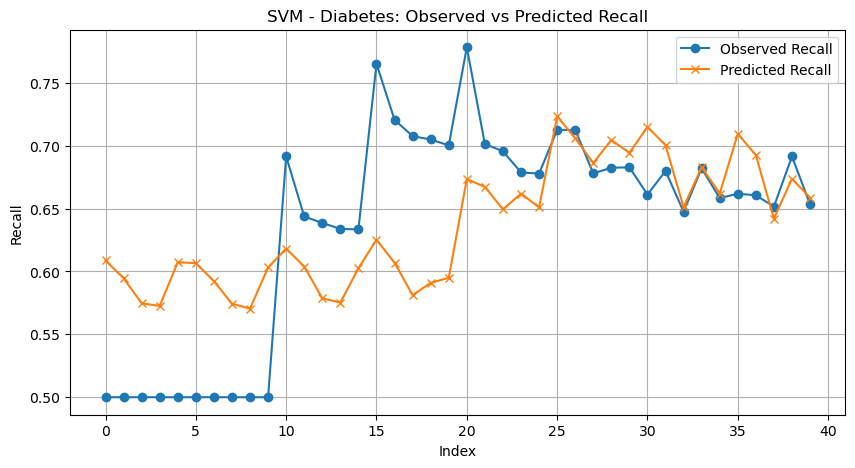

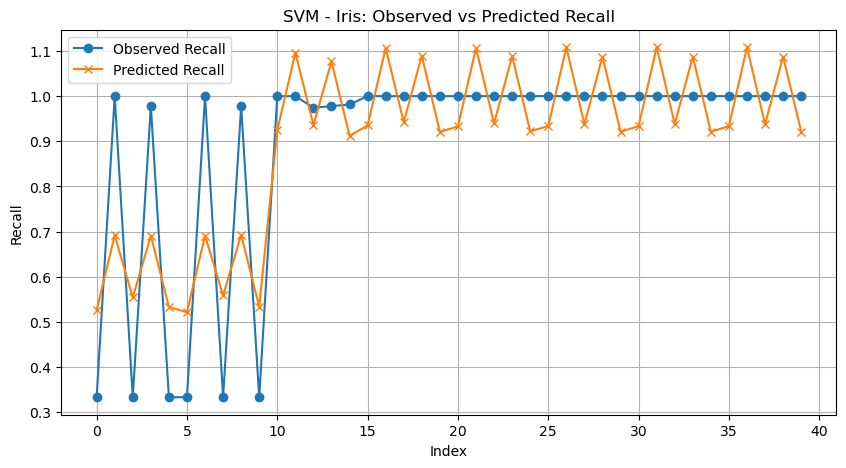

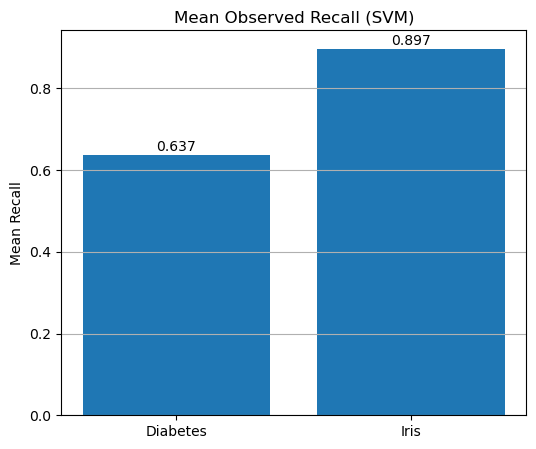

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import recall_score, mean_squared_error
from scipy.stats import entropy
from sklearn.linear_model import LinearRegression

# Function to compute active components for Recall: H_D, H_pred, H_local
def compute_entropies_and_recall(C, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    svm = SVC(C=C, kernel='rbf', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    probs = svm.predict_proba(X_test)

    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)

    # H_D: class distribution entropy from training set
    class_probs = np.bincount(y_train) / len(y_train)
    H_D = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_local: entropy of test set class distribution
    class_probs_test = np.bincount(y_test) / len(y_test)
    H_local = entropy(class_probs_test, base=2)

    return H_D, H_pred, H_local, rec

datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("Iris.csv", "Species")
]

for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"SVM - RECALL SCORE - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        data = pd.read_csv(csv_file)
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        data = data.dropna()
        
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        records = []
        for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_D, H_pred, H_local, rec = compute_entropies_and_recall(C, test_size=split)
                records.append({
                    "C": C,
                    "split": split,
                    "H_D": H_D,
                    "H_pred": H_pred,
                    "H_local": H_local,
                    "Recall": rec
                })
        
        df = pd.DataFrame(records)
        X_reg = df[["H_D", "H_pred", "H_local"]].values
        y_reg = df["Recall"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        coeffs = pd.DataFrame({
            "Entropy": ["H_D", "H_pred", "H_local"],
            "Coefficient (β)": model.coef_
        })
        
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: SVM")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted Recall:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table:")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        print(f"\nSummary Statistics:")
        print(f"Mean Observed Recall: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted Recall: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# ============================
# Extract observed & predicted
# ============================
obs_diabetes_svm = [
    0.5,0.5,0.5,0.5,0.5,
    0.5,0.5,0.5,0.5,0.5,
    0.691447,0.643704,0.638567,0.633827,0.633465,
    0.765132,0.720556,0.707582,0.704938,0.700243,
    0.778289,0.701296,0.695582,0.678765,0.677781,
    0.712500,0.712593,0.677970,0.682469,0.682796,
    0.661184,0.679815,0.647582,0.681975,0.658267,
    0.661842,0.660556,0.651582,0.691481,0.653343
]

pred_diabetes_svm = [
    0.608759,0.594616,0.574672,0.572596,0.607341,
    0.606593,0.592260,0.574382,0.570429,0.603201,
    0.618177,0.603922,0.578562,0.575306,0.602503,
    0.625251,0.606958,0.581134,0.590900,0.594958,
    0.673426,0.667203,0.649403,0.661845,0.650983,
    0.723311,0.705937,0.686237,0.704541,0.694315,
    0.714912,0.700368,0.651058,0.682918,0.661951,
    0.709409,0.692419,0.641953,0.673738,0.658687
]

obs_iris_svm = [
    0.333333,1.0,0.333333,0.977778,0.333333,
    0.333333,1.0,0.333333,0.977778,0.333333,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,1.0,1.0,1.0,
    1.0,1.0,1.0,1.0,1.0,
    1.0,1.0,1.0,1.0,1.0,
    1.0,1.0,1.0,1.0,1.0,
    1.0,1.0,1.0,1.0,1.0
]

pred_iris_svm = [
    0.525622,0.691751,0.554293,0.691093,0.533027,
    0.521548,0.691204,0.558684,0.692499,0.533793,
    0.924585,1.096111,0.936132,1.076955,0.912017,
    0.935220,1.106251,0.942494,1.089701,0.920831,
    0.932914,1.106555,0.939460,1.088522,0.922425,
    0.933583,1.108284,0.937838,1.087610,0.921182,
    0.933583,1.108284,0.937838,1.087610,0.921182,
    0.933583,1.108284,0.937838,1.087610,0.921182
]

# ============================
# 1. Line Plot - Diabetes
# ============================
plt.figure(figsize=(10,5))
plt.plot(obs_diabetes_svm, marker='o', label="Observed Recall")
plt.plot(pred_diabetes_svm, marker='x', label="Predicted Recall")
plt.title("SVM - Diabetes: Observed vs Predicted Recall")
plt.xlabel("Index")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 2. Line Plot - Iris
# ============================
plt.figure(figsize=(10,5))
plt.plot(obs_iris_svm, marker='o', label="Observed Recall")
plt.plot(pred_iris_svm, marker='x', label="Predicted Recall")
plt.title("SVM - Iris: Observed vs Predicted Recall")
plt.xlabel("Index")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 3. Bar Chart - Mean Recall
# ============================
mean_diabetes_svm = sum(obs_diabetes_svm) / len(obs_diabetes_svm)
mean_iris_svm = sum(obs_iris_svm) / len(obs_iris_svm)

plt.figure(figsize=(6,5))
plt.bar(["Diabetes", "Iris"], [mean_diabetes_svm, mean_iris_svm])
plt.text(0, mean_diabetes_svm + 0.01, f"{mean_diabetes_svm:.3f}", ha='center')
plt.text(1, mean_iris_svm + 0.01, f"{mean_iris_svm:.3f}", ha='center')
plt.title("Mean Observed Recall (SVM)")
plt.ylabel("Mean Recall")
plt.grid(axis='y')
plt.show()


KNN - RECALL SCORE - Processing Dataset: diabetes.csv (Target: Outcome)

Dataset: diabetes.csv | Classifier: KNN

Regression Coefficients:
Entropy  Coefficient (β)
    H_D       -48.535054
 H_pred         0.055378
H_local       -15.082530

Intercept (β₀): 60.01667
Model R² score: 0.35421
MSE: 0.00047
RMSE: 0.02159

Observed vs Predicted Recall:
 Index  Observed  Predicted  Difference
     0  0.656579   0.677785   -0.021206
     1  0.672778   0.648660    0.024118
     2  0.664657   0.652921    0.011735
     3  0.699630   0.661957    0.037672
     4  0.670881   0.657769    0.013112
     5  0.688158   0.702773   -0.014615
     6  0.658519   0.673096   -0.014577
     7  0.646269   0.675699   -0.029431
     8  0.647901   0.685072   -0.037171
     9  0.634043   0.679698   -0.045656
    10  0.676316   0.708269   -0.031953
    11  0.659259   0.678319   -0.019059
    12  0.661731   0.680904   -0.019172
    13  0.663580   0.690957   -0.027376
    14  0.667538   0.686746   -0.019208
    15  0.72

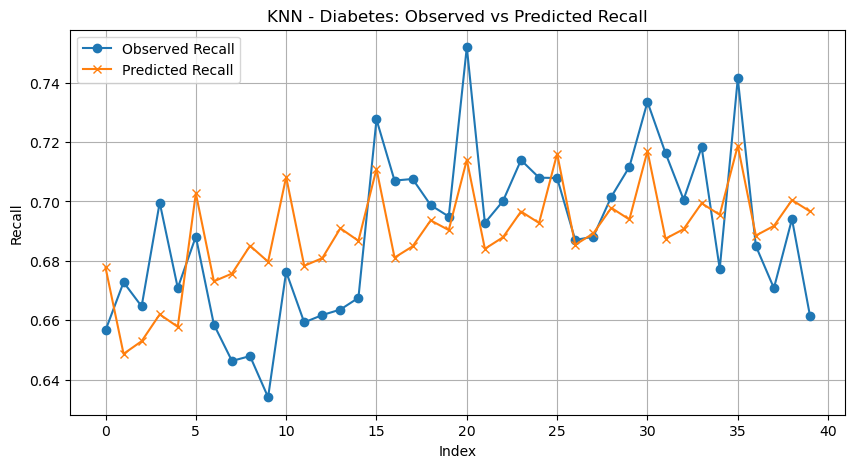

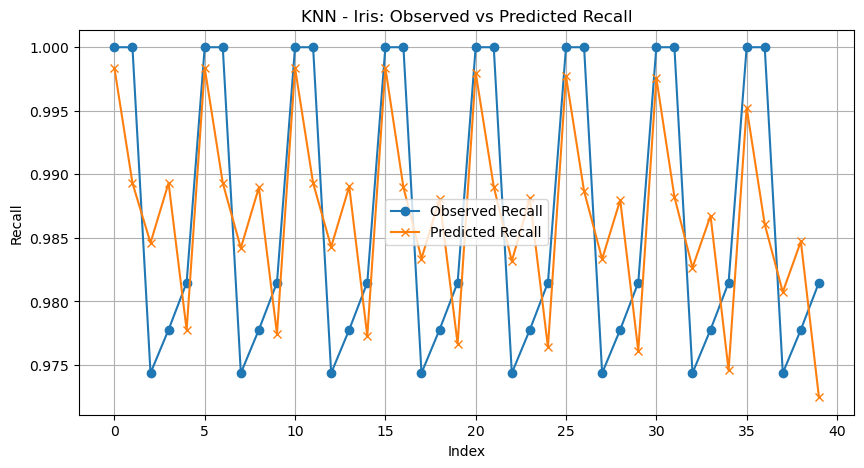

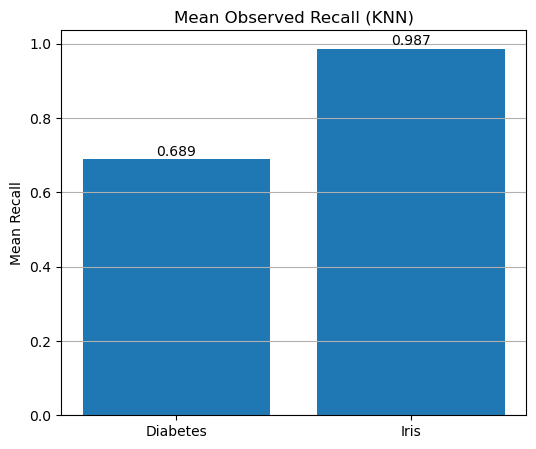

In [9]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import recall_score, mean_squared_error
from scipy.stats import entropy

# Function to compute active components for Recall: H_D, H_pred, H_local
def compute_entropies_and_recall(n_neighbors, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    probs = knn.predict_proba(X_test)

    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)

    # H_D: class distribution entropy from training set
    class_probs = np.bincount(y_train) / len(y_train)
    H_D = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_local: entropy of test set class distribution
    class_probs_test = np.bincount(y_test) / len(y_test)
    H_local = entropy(class_probs_test, base=2)

    return H_D, H_pred, H_local, rec

datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("Iris.csv", "Species")
]

for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"KNN - RECALL SCORE - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        data = pd.read_csv(csv_file)
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        data = data.dropna()
        
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        records = []
        for k in [1, 3, 5, 7, 9, 11, 15, 21]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_D, H_pred, H_local, rec = compute_entropies_and_recall(k, test_size=split)
                records.append({
                    "k": k,
                    "split": split,
                    "H_D": H_D,
                    "H_pred": H_pred,
                    "H_local": H_local,
                    "Recall": rec
                })
        
        df = pd.DataFrame(records)
        X_reg = df[["H_D", "H_pred", "H_local"]].values
        y_reg = df["Recall"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        coeffs = pd.DataFrame({
            "Entropy": ["H_D", "H_pred", "H_local"],
            "Coefficient (β)": model.coef_
        })
        
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: KNN")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted Recall:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table:")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        print(f"\nSummary Statistics:")
        print(f"Mean Observed Recall: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted Recall: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# ============================
# Extract observed & predicted
# ============================
obs_diabetes_knn = [
    0.656579,0.672778,0.664657,0.699630,0.670881,
    0.688158,0.658519,0.646269,0.647901,0.634043,
    0.676316,0.659259,0.661731,0.663580,0.667538,
    0.727632,0.707037,0.707582,0.698765,0.694924,
    0.751974,0.692778,0.700119,0.713951,0.708024,
    0.707895,0.687037,0.688119,0.701605,0.711672,
    0.733553,0.716296,0.700657,0.718272,0.677295,
    0.741447,0.685000,0.670806,0.694074,0.661337
]

pred_diabetes_knn = [
    0.677785,0.648660,0.652921,0.661957,0.657769,
    0.702773,0.673096,0.675699,0.685072,0.679698,
    0.708269,0.678319,0.680904,0.690957,0.686746,
    0.710973,0.681096,0.684887,0.693626,0.690364,
    0.714032,0.684051,0.687927,0.696617,0.692747,
    0.716104,0.685408,0.689214,0.697846,0.693930,
    0.716983,0.687461,0.690672,0.699397,0.695518,
    0.718804,0.688524,0.691763,0.700479,0.696643
]

obs_iris_knn = [
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481
]

pred_iris_knn = [
    0.998374,0.989317,0.984610,0.989317,0.977748,
    0.998374,0.989317,0.984197,0.988969,0.977452,
    0.998374,0.989317,0.984286,0.989043,0.977283,
    0.998374,0.988980,0.983370,0.988045,0.976668,
    0.998000,0.989031,0.983176,0.988106,0.976395,
    0.997721,0.988678,0.983330,0.987977,0.976117,
    0.997576,0.988238,0.982652,0.986739,0.974578,
    0.995239,0.986065,0.980733,0.984720,0.972460
]

# ============================
# 1. Line Plot - Diabetes
# ============================
plt.figure(figsize=(10,5))
plt.plot(obs_diabetes_knn, marker='o', label="Observed Recall")
plt.plot(pred_diabetes_knn, marker='x', label="Predicted Recall")
plt.title("KNN - Diabetes: Observed vs Predicted Recall")
plt.xlabel("Index")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 2. Line Plot - Iris
# ============================
plt.figure(figsize=(10,5))
plt.plot(obs_iris_knn, marker='o', label="Observed Recall")
plt.plot(pred_iris_knn, marker='x', label="Predicted Recall")
plt.title("KNN - Iris: Observed vs Predicted Recall")
plt.xlabel("Index")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 3. Bar Chart - Mean Recall
# ============================
mean_diabetes_knn = sum(obs_diabetes_knn) / len(obs_diabetes_knn)
mean_iris_knn = sum(obs_iris_knn) / len(obs_iris_knn)

plt.figure(figsize=(6,5))
plt.bar(["Diabetes", "Iris"], [mean_diabetes_knn, mean_iris_knn])
plt.text(0, mean_diabetes_knn + 0.01, f"{mean_diabetes_knn:.3f}", ha='center')
plt.text(1, mean_iris_knn + 0.01, f"{mean_iris_knn:.3f}", ha='center')
plt.title("Mean Observed Recall (KNN)")
plt.ylabel("Mean Recall")
plt.grid(axis='y')
plt.show()


Logistic Regression - RECALL SCORE - Processing Dataset: diabetes.csv (Target: Outcome)

Dataset: diabetes.csv | Classifier: Logistic Regression

Regression Coefficients:
Entropy  Coefficient (β)
    H_D       -79.818217
 H_pred         0.909438
H_local       -20.781776

Intercept (β₀): 93.94592
Model R² score: 0.87502
MSE: 0.00002
RMSE: 0.00455

Observed vs Predicted Recall:
 Index  Observed  Predicted  Difference
     0  0.707895   0.710074   -0.002180
     1  0.669259   0.676674   -0.007415
     2  0.685194   0.679068    0.006126
     3  0.692593   0.691213    0.001380
     4  0.696991   0.694902    0.002089
     5  0.707895   0.710074   -0.002180
     6  0.669259   0.676674   -0.007415
     7  0.685194   0.679068    0.006126
     8  0.692593   0.691213    0.001380
     9  0.696991   0.694902    0.002089
    10  0.707895   0.710074   -0.002180
    11  0.669259   0.676674   -0.007415
    12  0.685194   0.679068    0.006126
    13  0.692593   0.691213    0.001380
    14  0.696991   0

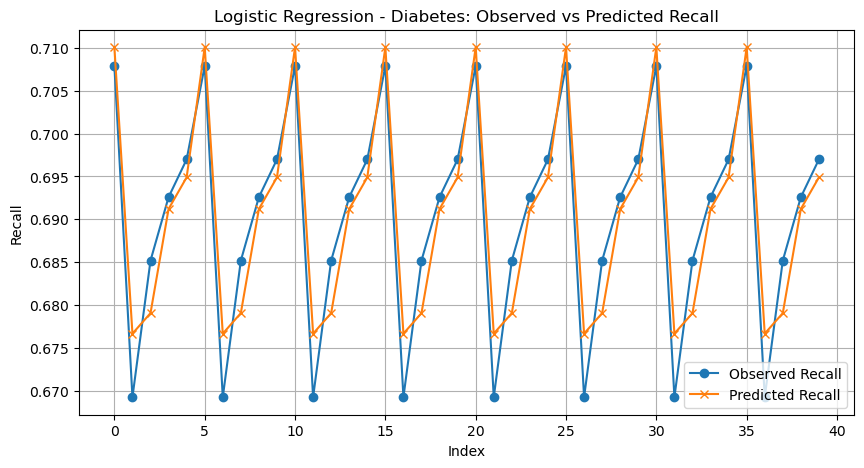

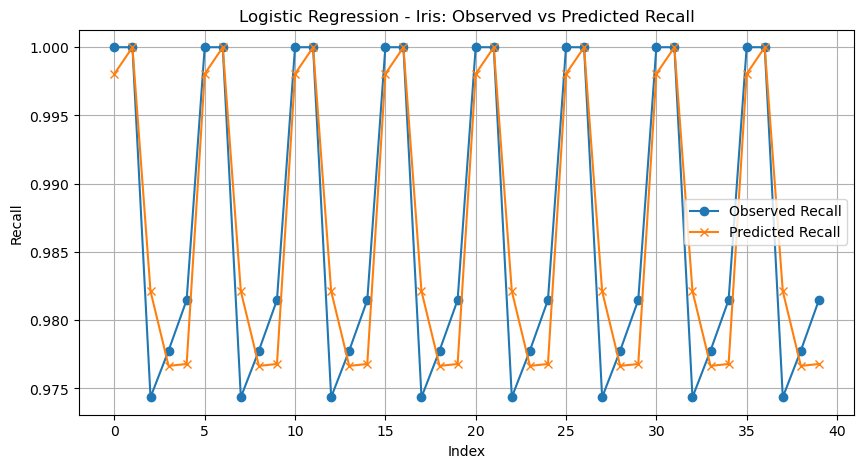

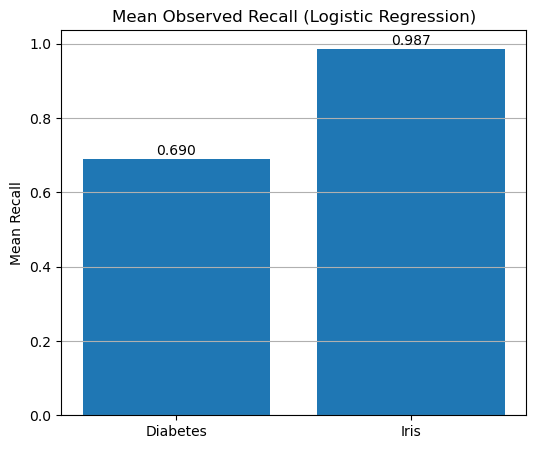

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import recall_score, mean_squared_error
from scipy.stats import entropy

# Function to compute active components for Recall: H_D, H_pred, H_local
def compute_entropies_and_recall(max_iter, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lr = LogisticRegression(max_iter=max_iter, solver='lbfgs', random_state=42)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    probs = lr.predict_proba(X_test)

    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)

    # H_D: class distribution entropy from training set
    class_probs = np.bincount(y_train) / len(y_train)
    H_D = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_local: entropy of test set class distribution
    class_probs_test = np.bincount(y_test) / len(y_test)
    H_local = entropy(class_probs_test, base=2)

    return H_D, H_pred, H_local, rec

datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("Iris.csv", "Species")
]

for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"Logistic Regression - RECALL SCORE - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        data = pd.read_csv(csv_file)
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        data = data.dropna()
        
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        records = []
        for max_iter in [100, 200, 500, 1000, 1500, 2000, 3000, 5000]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_D, H_pred, H_local, rec = compute_entropies_and_recall(max_iter, test_size=split)
                records.append({
                    "max_iter": max_iter,
                    "split": split,
                    "H_D": H_D,
                    "H_pred": H_pred,
                    "H_local": H_local,
                    "Recall": rec
                })
        
        df = pd.DataFrame(records)
        X_reg = df[["H_D", "H_pred", "H_local"]].values
        y_reg = df["Recall"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        coeffs = pd.DataFrame({
            "Entropy": ["H_D", "H_pred", "H_local"],
            "Coefficient (β)": model.coef_
        })
        
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: Logistic Regression")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted Recall:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table:")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        print(f"\nSummary Statistics:")
        print(f"Mean Observed Recall: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted Recall: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# ============================
# Extract observed & predicted
# ============================
obs_diabetes_lr = [
    0.707895,0.669259,0.685194,0.692593,0.696991,
    0.707895,0.669259,0.685194,0.692593,0.696991,
    0.707895,0.669259,0.685194,0.692593,0.696991,
    0.707895,0.669259,0.685194,0.692593,0.696991,
    0.707895,0.669259,0.685194,0.692593,0.696991,
    0.707895,0.669259,0.685194,0.692593,0.696991,
    0.707895,0.669259,0.685194,0.692593,0.696991,
    0.707895,0.669259,0.685194,0.692593,0.696991
]

pred_diabetes_lr = [
    0.710074,0.676674,0.679068,0.691213,0.694902,
    0.710074,0.676674,0.679068,0.691213,0.694902,
    0.710074,0.676674,0.679068,0.691213,0.694902,
    0.710074,0.676674,0.679068,0.691213,0.694902,
    0.710074,0.676674,0.679068,0.691213,0.694902,
    0.710074,0.676674,0.679068,0.691213,0.694902,
    0.710074,0.676674,0.679068,0.691213,0.694902,
    0.710074,0.676674,0.679068,0.691213,0.694902
]

obs_iris_lr = [
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481,
    1.0,1.0,0.974359,0.977778,0.981481
]

pred_iris_lr = [
    0.998047,0.999996,0.982127,0.976656,0.976792,
    0.998047,0.999996,0.982127,0.976656,0.976792,
    0.998047,0.999996,0.982127,0.976656,0.976792,
    0.998047,0.999996,0.982127,0.976656,0.976792,
    0.998047,0.999996,0.982127,0.976656,0.976792,
    0.998047,0.999996,0.982127,0.976656,0.976792,
    0.998047,0.999996,0.982127,0.976656,0.976792,
    0.998047,0.999996,0.982127,0.976656,0.976792
]

# ============================
# 1. Line Plot - Diabetes
# ============================
plt.figure(figsize=(10,5))
plt.plot(obs_diabetes_lr, marker='o', label="Observed Recall")
plt.plot(pred_diabetes_lr, marker='x', label="Predicted Recall")
plt.title("Logistic Regression - Diabetes: Observed vs Predicted Recall")
plt.xlabel("Index")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 2. Line Plot - Iris
# ============================
plt.figure(figsize=(10,5))
plt.plot(obs_iris_lr, marker='o', label="Observed Recall")
plt.plot(pred_iris_lr, marker='x', label="Predicted Recall")
plt.title("Logistic Regression - Iris: Observed vs Predicted Recall")
plt.xlabel("Index")
plt.ylabel("Recall")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 3. Bar Chart - Mean Recall
# ============================
mean_diabetes_lr = sum(obs_diabetes_lr) / len(obs_diabetes_lr)
mean_iris_lr = sum(obs_iris_lr) / len(obs_iris_lr)

plt.figure(figsize=(6,5))
plt.bar(["Diabetes", "Iris"], [mean_diabetes_lr, mean_iris_lr])
plt.text(0, mean_diabetes_lr + 0.01, f"{mean_diabetes_lr:.3f}", ha='center')
plt.text(1, mean_iris_lr + 0.01, f"{mean_iris_lr:.3f}", ha='center')
plt.title("Mean Observed Recall (Logistic Regression)")
plt.ylabel("Mean Recall")
plt.grid(axis='y')
plt.show()